# Introduction to Particle Swarm Optimization

**Authors:** Alexander Michels, Jeon-Young Kang, Shaowen Wang

![Gif of Particle Swarm Optimization](img/movie.gif)

This notebook is designed to teach you about Particle Swarm Optimization (PSO). Particle Swarm Optimization (PSO) was first introduced in [1995 by James Kennedy and Russell Eberhart](https://doi.org/10.1109/ICNN.1995.488968). The algorithm began as a simulation of social flocking behaviors like those exhibited by flocks of birds and schools of fish, specifically of birds searching a cornfield, but was found to be useful for training feedforward multilayer pernceptron neural networks. Since then, PSO has been adapted in a variety of ways and applied to problems including [wireless-sensor networks](https://doi.org/10.1109/TSMCC.2010.2054080), [classifying biological data](https://doi.org/10.1109/SIS.2005.1501608), [scheduling workflow applications in cloud computing environments](https://doi.org/10.1109/AINA.2010.31), [Image classification](https://doi.org/10.1109/ICIP.2006.312968) and [power systems](https://doi.org/10.1109/TEVC.2007.896686). In this notebook we explore PSO's usefulness for calibration, with a focus on spatially-explicit agent-based models (ABMs).

## Table of Contents

* [Particle Class](#part-class)
    * [Velocity Determination](#part-vel)
* [The PSO Class](#pso-class)
    * [PSO Topologies](#pso-top)
* [Running It](#running)
* [Running It on the Command Line](#running-cli)
* [Spatially-Explicit ABMs](#spatial-abm)
* [Learn More](#learn-more)

**Note: You must run the cell below to import the required packages or the rest of the notebook will not work.**
  

In [1]:
# import required packages
""" PSO class """
from PSO import *

""" Viz """
from IPython.display import Image, display, Markdown, Math
import ipywidgets
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import shutil
import warnings
%matplotlib inline
#warnings.filterwarnings('ignore')

""" Making sure you log/output folders """
if not os.path.exists("./logs"):
    os.mkdir("./logs")
if not os.path.exists("./outputs"):
    os.mkdir("./outputs")

<a id="part-class">
</a>

## Particle Class

Below is the code for a simple Particle that will makeup our swarm. The Particle has a few important functions:

* `__init__` - intializes the Particle object with a max velocity and bounds. The Particle picks a random point in the bounds as its initial position and generates a random velocity in $[-1,1]^N$ where $N$ is the dimension of the bounds.
* `copy_from` - copies position, velocity, and error information from another Particle object. Useful for syncing when using multi-processing.
* `evaluate` - evaluates the fitness of the Particle's position using the cost function if the Particle is in bounds. `func_sel` is a dictionary that provides information to the cost function such as particle position (`x`) and other necessary parameters. 
* `update_velocity` - uses its best position and its neighbors best position (`pos_best_g` which stands for position best global) to calculate a new velocity. This calculation uses a constriction factor and velocity clamping.


<a id="part-vel">
</a>

## Velocity Determination

![VelocityDetermination](img/VelocityDetermination.png)

Particles use input from their environment and their neighbors to try to figure out which direction will result in better positions. The original equation (Kenedy & Eberhart 1995) was:

$$\overrightarrow{v}_{t+1} = \overrightarrow{v}_{t}+2\cdot \beta_{1} (pbest-curr) + 2\cdot \beta_{2}(gbest-curr)$$

where $\overrightarrow{v}_{i}$ is velocity at timestep $i$, $\beta_{1},\beta_{2}$ are uniform random variables [0,1], curr is the current position, pbest is the personal best position, and gbest is the global best position. The calculation means that a particle's velocity is a sum of its current velocity (momentum), cognitive/individual input, and social input. They note in their paper that "the stochastic factor was multiplied by 2 to give it a mean of 1 so that agents would "overfly" the target about half the time"

Our velocity determination is very similar, but uses a few suggested improvements. Much of our improvements come from a paper by Bratton & Kennedy ([Defining a Standard for Particle Swarm Optimization](https://doi.org/10.1109/SIS.2007.368035)). Two particularly helpful improvments described by Bratton & Kennedy are due to the work of Clerc ([The swarm and the queen: towards a deterministic and adaptive particle swarm optimization](https://doi.org/10.1109/CEC.1999.785513)) and Eberhart & Shi ([Comparing inertia weights and constriction factors in particle swarm optimization](https://doi.org/10.1109/CEC.2000.870279)) who suggested a "constriction factor" to help the algorithm converge and using maximum velocities to limit particles from shooting off away from the bounds. Using the work from these papers, the new velocity update formula is:

$$\overrightarrow{v}_{t+1}=\chi (\overrightarrow{v}_{t}+c_{1}\beta_{1}(pbest-curr)+c_{2}\beta_{2}(gbest-curr))$$

$$\chi = \frac{2}{\|2-\phi-\sqrt{\phi^{2}-4\phi}\|}, \phi=c_{1},c_{2}$$

$\chi$ above describes the constriction factor and as discussed in [Bratton & Kennedy's paper](https://doi.org/10.1109/SIS.2007.368035), $\phi=4.1$ ensures convergence, thus giving us that $c_{1},c_{2}=2.05$ and $\chi\approx0.72984$. Note that here "gbest" refers to "the best position obtained by the particle's neighbors" which can be the global best if all particles are connected, but varies based on the topology of the particle communication structure (see below).

In [2]:
# data for plotting velocity
beta_1, beta_2 = random.random(), random.random()
curr = [0,0] # current location
v_t = [4, -6] # current velocity
pbest = [-7,2] # person best location
gbest = [9,8] # global best location (according to neighbors)

Below you can explore how simple velocity determination works. The colors match the figure above so:

* Red represents the current velocity
* Blue represents the individual influence
* Green represents the social influence
* Orange is the new velocity

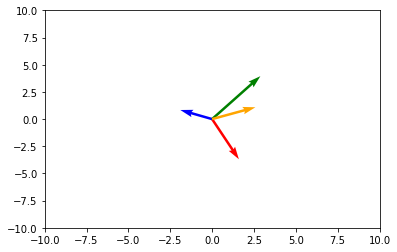

In [3]:
# plot velocity determination
# basic (no constriction factor) velocity determination
origin = np.array([[curr[0]]*4,[curr[1]]*4]) # current location
individual = 2*beta_1*np.subtract(pbest, curr)
social = 2*beta_2*np.subtract(gbest, curr)
v_t1 = np.add(np.add(v_t, individual), social)
V = np.array([v_t, individual, social, v_t1])

plt.xlim([-10,10])
plt.ylim([-10,10])
plt.quiver(*origin, V[:,0], V[:,1], color=['r','b','g','orange'],scale=50)
plt.show()

Below you can see the effect of using the constriction factor.

<IPython.core.display.Math object>

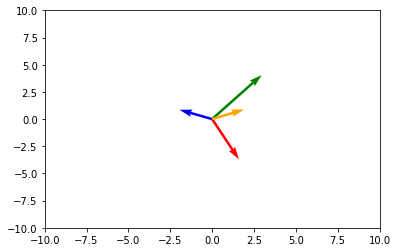

In [4]:
# plot velocity determination
# using constriction factor
c1 = 2.05        # cognitive constant
c2 = 2.05        # social constant
phi = c1 + c2
k = 2.0 / abs(2 - phi - math.sqrt(phi ** 2 - 4 * phi))
display(Math(r'c_1 = {} \\c_2 = {},\\ \phi = {}\\ \chi = {}'.format(c1,c2,phi,k)))

origin = np.array([[curr[0]]*4,[curr[1]]*4]) # current location
individual = c1*beta_1*np.subtract(pbest, curr)
social = c2*beta_2*np.subtract(gbest, curr)
v_t1 = k*np.add(np.add(v_t, individual), social)
V = np.array([v_t, individual, social, v_t1])

plt.xlim([-10,10])
plt.ylim([-10,10])
plt.quiver(*origin, V[:,0], V[:,1], color=['r','b','g','orange'],scale=50)
plt.show()

*The vectors above look the same, so what's the difference?*

As mentioned above, the constriction factor comes from work by [Eberhart & Shi](https://doi.org/10.1109/CEC.2000.870279) which found that "the best approach to use with particle swarm optimization as a 'rule of thumb' is to utilize the constriction factor approach". This is useful because it ensures that the particles will converge on a single solution.

<a id="pso-class"> </a>

## The PSO Class

The class below looks long and complicated, but rest assured, much of the code is dealing with PSO parameters and logging the results out. The functions are:

* `__init__` - Initializes a swarm and calls the other necessary functions for PSO. It takes in a cost function (`costFunc`), bounds (`bounds`) and an argument dictionary which is used for PSO parameters such as whether or not to make a gif.
* `set_neighbor_graph` - sets a neighbor graph for the Particles. Neighbors communicate about most fit positions.
* `optimize` - the optimization loop. Until we reach a given number of generations/iterations, the optimize loop
* `generate_gif` - generate a gif of the run. This also means that the surface will be plotted at each step which is not feasible for computationally intensive functions like ABMs.
* `plot_surface` - plots the surface with the history of the particles. Again note that this is not feasible for computationally intensive functions.
* `plot_surface_this_timestep` - used if `gif==True` to produce a snapshot of the surface with the particle position and movement at eash timestep. These snapshots are compiled into a gif at the end of the run

<a id="pso-top">
</a>


## PSO Topology

![PSO Topologies](img/PSOTopologies.png)

The original Particle Swarm Optimization implementation relied on a "global best", but there has been extensive work to explore different communication network structures. The two most commonly explored graph structures are usually referred to as "gbest/global best" which describes a fully connected graph where each particle is connected to each other and "lbest/local best" which describes a graph where each particle is only connected to two others forming a ring. The are illustrated in the above figure on the left and right. In our implementation, they are called "fullyconnected" and "ring". Work has also been done to explore other topologies like random graphs, "pyramid", "star", "small world", and von Neumann based on von Neumann neighborhoods. I highly recommend the papers by Kennedy & Mendes ([Population Structure and Particle Swarm Performance](https://doi.org/10.1109/CEC.2002.1004493)) as well as Bratton & Kennedy's work ([Defining a Standard for Particle Swarm
Optimization](https://doi.org/10.1109/SIS.2007.368035)) as a starting point. Kennedy & Mendes found that von Neumann worked most consistently while more recent work by Bratton & Kennedy recommends a ring topology.

In [5]:
# function for creating graph describing communication between particles
def set_neighbor_graph(num_particles, topology):  # add more topologies
    neighbor_graph = np.zeros((num_particles, num_particles))  # turn into numpy structure
    if topology == "fullyconnected":
        for i in range(num_particles):
            for j in range(num_particles):
                neighbor_graph[i, j] = 1
    elif topology == "ring":
        for i in range(num_particles):
            for j in range(num_particles):
                if j == i - 1 or j == i + 1:
                    neighbor_graph[i, j] = 1
                elif i == 0 and j == num_particles - 1:
                    neighbor_graph[i, j] = 1
                elif i == num_particles - 1 and j == 0:
                    neighbor_graph[i, j] = 1
    elif topology == "vonNeumann":
        """ https://doi.org/10.1109/CEC.2002.1004493 """
        n = num_particles
        r = math.floor(math.sqrt(n))
        for i in range(n):
            neighbor_graph[i, (i + 1) % n] = 1
            neighbor_graph[(i + 1) % n, i] = 1
            neighbor_graph[i, (i - 1) % n] = 1
            neighbor_graph[(i - 1) % n, i] = 1
            neighbor_graph[i, (i + r) % n] = 1
            neighbor_graph[(i + r) % n, i] = 1
    return neighbor_graph

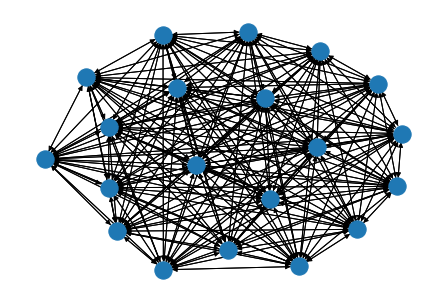

In [6]:
# fullyconnected topology
num_particles = 20
A = set_neighbor_graph(num_particles, "fullyconnected")
G = nx.from_numpy_matrix(A, create_using=nx.DiGraph)
nx.draw(G)

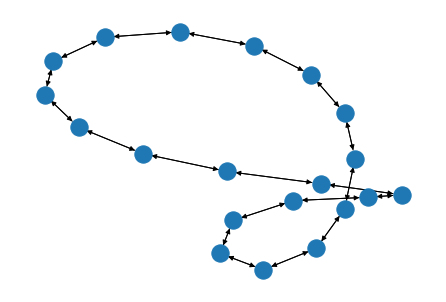

In [7]:
# ring topology
A = set_neighbor_graph(num_particles, "ring")
G = nx.from_numpy_matrix(A, create_using=nx.DiGraph)
nx.draw(G)

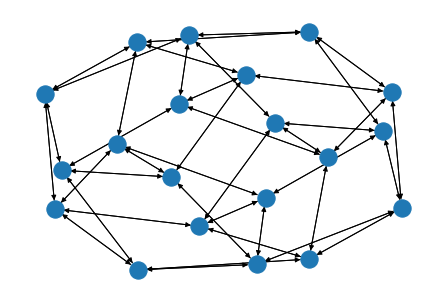

In [8]:
# vonNeumann topology
A = set_neighbor_graph(num_particles, "vonNeumann")
G = nx.from_numpy_matrix(A, create_using=nx.DiGraph)
nx.draw(G)

<a id="running"></a>

## Running It

Below you can run PSO on a simple function! The functions below are common benchmark functions, to learn more about each function, click the link:

* [Eggholder](https://web.archive.org/web/20200731072833/https://www.sfu.ca/~ssurjano/egg.html)
* [Michalewicz (michal)](https://web.archive.org/web/20200731072833/https://www.sfu.ca/~ssurjano/michal.html)
* [Paraboloid/Sphere](http://benchmarkfcns.xyz/benchmarkfcns/spherefcn.html)
* [Rastrigin](http://benchmarkfcns.xyz/benchmarkfcns/rastriginfcn.html)
* [Shubert](http://benchmarkfcns.xyz/benchmarkfcns/shubertfcn.html)

To add more functions like those [seen on Wikipedia](https://en.wikipedia.org/wiki/Test_functions_for_optimization) and [this site](http://benchmarkfcns.xyz/fcns) simply add them to 

**Note: the slowness is a result of plotting at every iteration. The functions are trivially easy to compute**

In [9]:
# create dropdowns for algorithm parameters
func_dropdown = ipywidgets.Dropdown(
    options=get_standard_funcs(),
    description = "Cost Func",
    value=paraboloid
)
generations_slider = ipywidgets.IntSlider(
    value=36,
    min=1,
    max=120,
    step=1,
    description="N Generations"
)
part_slider = ipywidgets.IntSlider(
    value=20,
    min=1,
    max=100,
    step=1,
    description='N Particles'
)
topology_dropdown = ipywidgets.Dropdown(
    options=[ "fullyconnected", "ring", "vonNeumann" ],
    description="Topology",
    value="ring"
)
display(func_dropdown,generations_slider,part_slider,topology_dropdown)

Dropdown(description='Cost Func', index=2, options=(('eggholder', <function eggholder at 0x7f7edcbe64c0>), ('m…

IntSlider(value=36, description='N Generations', max=120, min=1)

IntSlider(value=20, description='N Particles', min=1)

Dropdown(description='Topology', index=1, options=('fullyconnected', 'ring', 'vonNeumann'), value='ring')

In [10]:
# pass the arguments into the PSO function and run it
args = {
    "gif" : "True",
    "headless" : "False",
    "max_velocity" : "inf",
    "metric" : "rmse",
    "output_dir" : "",
    "particles" : part_slider.value,
    "seed" : "None",
    "threads" : 1,
    "topology" : topology_dropdown.value,
    "termination": {
         "termination_criterion" : "iterations",
         "max_iterations" : generations_slider.value
    },
    "function": {
        "dim_description" : "None",
        "dimension" : 2,
        "function" : func_dropdown.value.__name__
    }
}

pprint(args)
swarm = PSO(func_dropdown.value, get_bounds(func_dropdown.value,2), args)
print("True min is {} at {}".format(*get_global_minima(swarm.costFunc, 2)))

print("\nThe results can found at the run's output director: {}".format(swarm.output_path))
print("\nThe log for the run can be found at {}. Here is small preview:".format(swarm.log_file))
with open(swarm.log_file) as myfile:
    for i in range(3):
        print(next(myfile))

{
    "function": {
        "dim_description": "None",
        "dimension": 2,
        "function": "paraboloid"
    },
    "gif": "True",
    "headless": "False",
    "max_velocity": "inf",
    "metric": "rmse",
    "output_dir": "",
    "particles": 20,
    "seed": "None",
    "termination": {
        "max_iterations": 36,
        "termination_criterion": "iterations"
    },
    "threads": 1,
    "topology": "ring"
}
|-----+-------------------+-----------------------------------------
| Gen | Global Best Error | Global Best Pos 
|-----+-------------------+-----------------------------------------
| 0   | inf               | [] 
| 1   |        616.605304 | [24.743098889695688, 2.0938867036467883] 
| 2   |        187.494170 | [-3.007522322621398, -13.358479683160025] 
| 3   |        187.494170 | [-3.007522322621398, -13.358479683160025] 
| 4   |        186.044790 | [-3.3730993437158414, -13.21616400971305] 
| 5   |        186.044790 | [-3.3730993437158414, -13.21616400971305] 
| 6   |  

<Figure size 864x720 with 0 Axes>

The particle neighbor graph is:

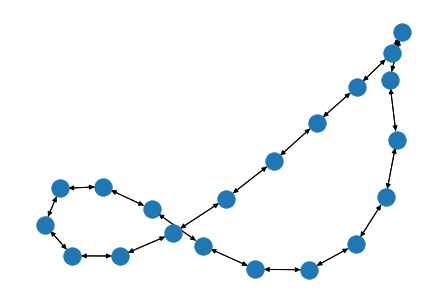

In [11]:
# plot the neighbor graph
G = nx.from_numpy_matrix(swarm.neighbor_graph, create_using=nx.DiGraph)
nx.draw(G)

This is the CSV file that holds information on the position and error of each particle throughout the run.

In [12]:
# showing the result CSV created
result_csv = pd.read_csv(swarm.csv_out.name)
result_csv.head()

Iteration  Particle 0's x[0] Position  Particle 0's x[1] Position  \
0          0                   57.713283                  -37.657788   
1          1                   14.652006                   39.021674   
2          2                  -24.205222                   92.901491   
3          3                  -30.033490                   72.770988   
4          4                  -26.628991                  -18.122666   

   Particle 0's Error  Particle 1's x[0] Position  Particle 1's x[1] Position  \
0         4748.931991                   13.483884                   26.407707   
1         1737.372304                    0.173291                   26.838386   
2         9216.579868                  -30.550809                    7.836110   
3         6197.627136                  -51.183783                  -15.965814   
4         1037.534194                  -66.177883                  -31.370238   

   Particle 1's Error  Particle 2's x[0] Position  Particle 2's x[1] Position  \
0          879.182109                  -19.837361                  -19.232813   
1          720.328983                  -18.209677                   -7.574254   
2          994.756534                  -16.984912                   -6.109926   
3         2874.686824                   -3.373099                  -13.216164   
4         5363.603944                    3.977009                  -19.242518   

   Particle 2's Error  ...  Particle 17's x[0] Position  \
0          763.421983  ...                   -39.406719   
1          388.961657  ...                     8.365049   
2          325.818429  ...                     4.150126   
3          186.044790  ...                   -32.720918   
4          386.091115  ...                   -48.870434   

   Particle 17's x[1] Position  Particle 17's Error  \
0                    54.236976          4494.539022   
1                   -87.525958          7730.767335   
2                  -131.385259                  inf   
3                    25.267819          1709.121184   
4                   146.103826                  inf   

   Particle 18's x[0] Position  Particle 18's x[1] Position  \
0                    22.345424                   -55.313389   
1                    49.715618                   -46.724186   
2                    55.672134                   -38.600608   
3                    57.797351                    40.304185   
4                     0.677816                    80.092936   

   Particle 18's Error  Particle 19's x[0] Position  \
0          3558.888949                    56.866245   
1          4654.792202                    39.073024   
2          4589.393430                    -4.766440   
3          4964.961169                   -14.506055   
4          6415.337909                    15.828444   

   Particle 19's x[1] Position  Particle 19's Error  Average Error  
0                   -29.847890          4124.666349    5545.905113  
1                   -31.981410          2549.511813            inf  
2                    17.959338           345.256760            inf  
3                    56.972250          3456.262871            inf  
4                    68.797745          4983.669389            inf  

[5 rows x 62 columns]

Here is plot of the surface, with arrows representing the particles flying around the space

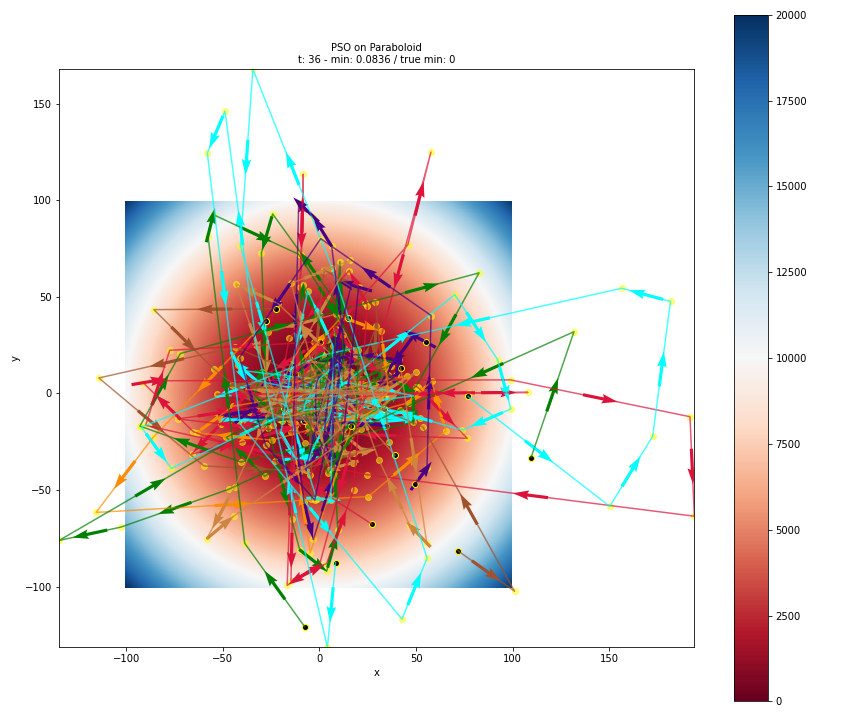

In [13]:
# plot the surface of the function with particles
Image(filename=os.path.join(swarm.output_path, "surface.png"))

### Below you can see a gif of the particles moving around your space!

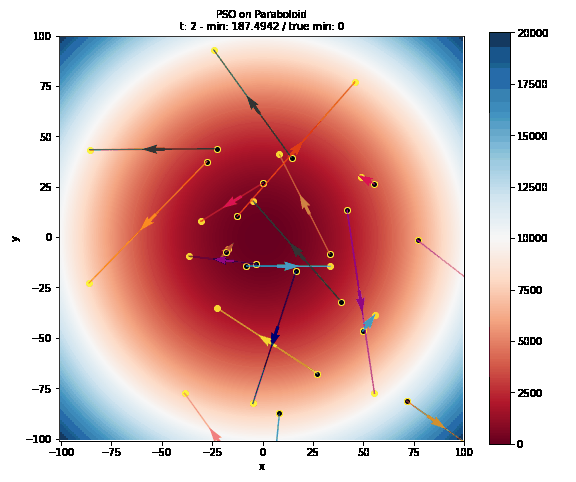

In [14]:
# plot the gif created by the algorithm
Image(filename=os.path.join(swarm.output_path, "movie.gif"))

<a id="running-cli"> </a>

# Running from the Command Line

The code works from the command line if you specify the path to the params JSON:

In [15]:
!python3 PSO.py --params test.json

...loading parameters from test.json...
{
    "function": {
        "dim_description": "None",
        "dimension": 2,
        "function": "eggholder"
    },
    "gif": "True",
    "headless": "False",
    "max_velocity": "inf",
    "metric": "rmse",
    "output_dir": "",
    "particles": 20,
    "seed": "None",
    "termination": {
        "max_iterations": 36,
        "termination_criterion": "iterations"
    },
    "threads": 1,
    "topology": "fullyconnected"
}
Swarming with 20 particles on 1 threads using iterations termination criterion with inf vmax
Running Eggholder....

|-----+-------------------+-----------------------------------------
| Gen | Global Best Error | Global Best Pos 
|-----+-------------------+-----------------------------------------
| 0   | inf               | [] 
| 1   |       -392.462446 | [325.04553023545134, 198.24838800134887] 
| 2   |       -393.976642 | [301.4819551009189, 208.29563307592446] 
| 3   |       -416.449102 | [215.28257254805, 232.042017896

<a id="spatial-abm">
</a>

## Spatially Explicit ABMs

![Map of influenza cases](img/InfluenzaCases.png)

Our interest in PSO is for calibrating spatially-explicit agent-based models (ABMs). In particular, we chose a model [of influenza transmission developed by Jeon-Young Kang](https://doi.org/10.1145/3356470.3365531). A notebook for a very similar version of this model (focuses on the Queene Anne neighborhood of Seattle) is [available on CyberGISX as well if you'd like to explore the model more indepth](https://cybergisxhub.cigi.illinois.edu/notebook/a-reproducible-and-replicable-spatially-explicit-agent-based-model-using-cybergis-jupyter-a-case-study-in-queen-anne-neighborhood-seattle-wa/).

Calibrating spatially-explicit ABMs often depend on the concept of [pattern-oriented validation](https://search.proquest.com/openview/9b2d012f5aa1a575a945ddf0f364e11b/1?pq-origsite=gscholar&cbl=18750&diss=y). Pattern-Oriented Validation is based on Pattern-Oriented Modeling (POM) which seeks to replicate observed patterns using simulation. In the case of the influenza model, the pattern is the curve describing the number of cases over a flu season and we calibrate by getting the simulated curve as close as possible to this line (measured by RMSE). For our model, we were able to obtain influenza case data from the Florida Department of Health.

![Influenza cases over time](img/InfectionCases.png)

**NOTE: The spatially explicit ABM can take 30-120 minutes per run meaning that a single generation with 20 particles can take 10-40 hours *per generation*. It is not recommended to do this on here, but rather on cyberinfrastructure with a large number of threads to speed this up.**

<a id="learn-more">
</a>

# Learn More!

## PSO

#### Overview / Introductory Papers

* [Defining a Standard for PSO](https://doi.org/10.1109/SIS.2007.368035)
* [Particle swarm optimization](https://doi.org/10.1109/ICNN.1995.488968)
* [Particle swarm optimization: developments, applications and resources](https://doi.org/10.1109/CEC.2001.934374)
* [Particle Swarm Optimization: An Overview](https://doi.org/10.1007/s11721-007-0002-0)

#### Selected Applications

* [A hybrid particle swarm/ant colony algorithm for the classification of hierarchical biological data](https://doi.org/10.1109/SIS.2005.1501608)
* [A particle swarm optimization-based heuristic for scheduling workflow applications in cloud computing environments](https://doi.org/10.1109/AINA.2010.31)
* [Image classification using chaotic particle swarm optimization](https://doi.org/10.1109/ICIP.2006.312968)
* [Particle swarm optimization: basic concepts, variants and applications in power systems](https://doi.org/10.1109/TEVC.2007.896686)
* [Particle swarm optimization in wireless-sensor networks: A brief survey](https://doi.org/10.1109/TSMCC.2010.2054080)

## Calibrating Spatially-Explicit ABM

* [Pattern-Oriented Validation and Sensitivity Analysis Methods for Spatially Explicit Agent-Based Models](https://search.proquest.com/openview/9b2d012f5aa1a575a945ddf0f364e11b/1?pq-origsite=gscholar&cbl=18750&diss=y)
* [Using multiple scale space-time patterns in variance-based global sensitivity analysis for spatially explicit agent-based models](https://doi.org/10.1016/j.compenvurbsys.2019.02.006)
* [Using multiple scale spatio-temporal patterns for validating spatially explicit agent-based models](https://doi.org/10.1080/13658816.2018.1535121)

In [16]:
""" Cleaning up: deleting the outputs to reduce disk usage """
# you can comment these lines if you want to keep the data
!rm -r ./logs/*
!rm -r ./outputs/*